# COGS 108 - EDA Checkpoint

# Names

- Cairo Simpson
- Michelle Liu
- Michael Donaldson
- Matthew Leffler
- Charmie Donasco

<a id='research_question'></a>
# Research Question

How have the musical characteristics of Kanye West evolved from their first album, the College Dropout, to their latest, Donda (Deluxe)?

# Setup

In [1]:
import pandas as pd
# pd.set_option('display.max_rows', None)

import nltk
import string
import json
import re
from urllib.request import urlopen

from nltk.sentiment.vader import SentimentIntensityAnalyzer 

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 14})

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/m2liu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/m2liu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/m2liu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Data Cleaning

Here, we can take a glimpse at the two datasets that we are working with.

In [2]:
df_spotify = pd.read_csv('spotify_features.csv')
df_spotify.head()

,Track Name,Album,Release Date,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,Intro,The College Dropout,2004-02-10,0.713,0.331,6,-13.909,1,0.8770,0.2370,0.000000,0.510,0.463,87.491
1,We Don't Care,The College Dropout,2004-02-10,0.595,0.754,11,-5.827,0,0.1810,0.0142,0.000000,0.247,0.647,83.155
2,Graduation Day,The College Dropout,2004-02-10,0.418,0.447,0,-9.058,0,0.3380,0.6840,0.000002,0.414,0.869,169.336
3,All Falls Down,The College Dropout,2004-02-10,0.657,0.734,8,-4.832,0,0.4840,0.1490,0.000000,0.139,0.434,91.030
4,I'll Fly Away,The College Dropout,2004-02-10,0.239,0.250,6,-11.414,1,0.0289,0.7600,0.000000,0.124,0.564,172.338


In [3]:
df_lyrics = pd.read_csv('lyrics.csv')
df_lyrics.head()

,Track Name,Album,Lyrics
0,Intro by Kanye West,The College Dropout,"Intro Lyrics\nKanye, can I talk to you for a m..."
1,We Don't Care by Kanye West,The College Dropout,"We Don’t Care Lyrics\nOh, yeah\nI got the perf..."
2,Graduation Day by Kanye West,The College Dropout,Graduation Day Lyrics\nWhat in the fuck was th...
3,All Falls Down by Kanye West (Ft. Syleena John...,The College Dropout,"All Falls Down Lyrics\nOh, when it all, it all..."
4,I'll Fly Away by Kanye West,The College Dropout,"I’ll Fly Away Lyrics\nOne glad morning, when t..."


While the Spotify features dataset was pulled in a pretty clean manner that does not require much changes, there are definitely a few issues in the lyrics dataset. Namely, the track names aren't coherent with the Spotify dataset, and the lyrics are initialized with their respective song names.

Regarding the former, we can make a relatively simple fix by removing everything after the word 'by', since none of his actual songs seem to have the actual word. The latter could be fixed pretty easily as well by looking at everything after the first line break, which is denoted by a 'Lyrics'. Additionally, we'll also go ahead and expand out all contractions easier pre-processing.

In [4]:
def fix_song_name(song_name):
    song_name = str(song_name)
    return song_name.split(' by')[0]

def fix_lyrics(lyrics):
    lyrics = str(lyrics)
    split = lyrics.split('Lyrics', 1)
    if len(split) > 1:
        return split[1]
    else:
        return lyrics
    
def expand(lyrics):
    lyrics = re.sub(r"won\'t", "will not", lyrics)
    lyrics = re.sub(r"can\'t", "cannot", lyrics)
    lyrics = re.sub(r"n\'t", " not", lyrics)
    lyrics = re.sub(r"\'re", " are", lyrics)
    lyrics = re.sub(r"\'s", " is", lyrics)
    lyrics = re.sub(r"\'d", " would", lyrics)
    lyrics = re.sub(r"\'ll", " will", lyrics)
    lyrics = re.sub(r"\'t", " not", lyrics)
    lyrics = re.sub(r"\'ve", " have", lyrics)
    lyrics = re.sub(r"\'m", " am", lyrics)
    return lyrics

df_lyrics['Track Name'] = df_lyrics['Track Name'].map(fix_song_name)
df_lyrics['Lyrics'] = df_lyrics['Lyrics'].map(fix_lyrics)
df_lyrics['Lyrics'] = df_lyrics['Lyrics'].map(expand)
df_lyrics

,Track Name,Album,Lyrics
0,Intro,The College Dropout,"\nKanye, can I talk to you for a minute?\nMe a..."
1,We Don't Care,The College Dropout,"\nOh, yeah\nI got the perfect song for the kid..."
2,Graduation Day,The College Dropout,"\nWhat in the fuck was that, Kanye?! I told yo..."
3,All Falls Down,The College Dropout,"\nOh, when it all, it all falls down\nYeah, th..."
4,I'll Fly Away,The College Dropout,"\nOne glad morning, when this life is over, I ..."
...,...,...,...
200,Jesus Lord,Donda (Deluxe),\nTell me if you know someone that needs (Jesu...
201,Ok Ok pt 2 (Deluxe Version),Donda (Deluxe),"\nOkay, now they got me wanna rap again\nHeale..."
202,Junya pt 2,Donda (Deluxe),"\nJunya Watanabe on my wri', wri'\nJunya Watan..."
203,Jail pt 2,Donda (Deluxe),\nTake what you want\nTake everything\nTake wh...


Upon closer inspection of the data, there are also a few entries here that are invalid. Four of these entries are 'booklets', and are not actually songs or even part of the album. One of these entries is a part of an album, but is purely instrumental. We'll go ahead and remove all of these.

In [5]:
df_lyrics = df_lyrics.drop(df_lyrics.index[[22, 46, 62, 78, 147]])
df_lyrics.reset_index()

,index,Track Name,Album,Lyrics
0,0,Intro,The College Dropout,"\nKanye, can I talk to you for a minute?\nMe a..."
1,1,We Don't Care,The College Dropout,"\nOh, yeah\nI got the perfect song for the kid..."
2,2,Graduation Day,The College Dropout,"\nWhat in the fuck was that, Kanye?! I told yo..."
3,3,All Falls Down,The College Dropout,"\nOh, when it all, it all falls down\nYeah, th..."
4,4,I'll Fly Away,The College Dropout,"\nOne glad morning, when this life is over, I ..."
...,...,...,...,...
195,200,Jesus Lord,Donda (Deluxe),\nTell me if you know someone that needs (Jesu...
196,201,Ok Ok pt 2 (Deluxe Version),Donda (Deluxe),"\nOkay, now they got me wanna rap again\nHeale..."
197,202,Junya pt 2,Donda (Deluxe),"\nJunya Watanabe on my wri', wri'\nJunya Watan..."
198,203,Jail pt 2,Donda (Deluxe),\nTake what you want\nTake everything\nTake wh...


In order to prepare for lexical analysis, we also need to do a bit of pre-processing using the nltk library. We'll first start off by lowercasing and tokenizing the lyrics. We also notice that from doing this process that the last string in the array is an "##Embed" string, which isn't part of the actual lyrics, so we'll also remove that as well. Furthermore, we'll go ahead and remove the stop words from the lyrics, since they won't carry any meaningful weight to our analysis. Lastly, we'll perform lexicon normalization to standardize similar words through lemmatization, which returns the base word (lemma) of each phrase in an improved manner from stemming.

In [6]:
def create_lyrics_token(lyrics):
    lyrics = lyrics.lower()
    lyrics = nltk.tokenize.word_tokenize(lyrics)
    lyrics.pop()
    return lyrics

# tokenization
df_lyrics['lyrics_token'] = df_lyrics['Lyrics'].apply(create_lyrics_token)

# stop words
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.update(string.punctuation)
stop_words.update(['"', "''", '`', '``'])
stop_words.remove('!')
stop_words.remove('?')
df_lyrics['lyrics_stop'] = df_lyrics['lyrics_token'].apply(lambda x: [item for item in x if item not in stop_words])

# lemmatization
lemma = nltk.wordnet.WordNetLemmatizer()
df_lyrics['lyrics_lem'] = df_lyrics['lyrics_stop'].apply(lambda x: [lemma.lemmatize(y) for y in x])

df_lyrics

,Track Name,Album,Lyrics,lyrics_token,lyrics_stop,lyrics_lem
0,Intro,The College Dropout,"\nKanye, can I talk to you for a minute?\nMe a...","[kanye, ,, can, i, talk, to, you, for, a, minu...","[kanye, talk, minute, ?, faculty, members, won...","[kanye, talk, minute, ?, faculty, member, wond..."
1,We Don't Care,The College Dropout,"\nOh, yeah\nI got the perfect song for the kid...","[oh, ,, yeah, i, got, the, perfect, song, for,...","[oh, yeah, got, perfect, song, kids, sing, peo...","[oh, yeah, got, perfect, song, kid, sing, peop..."
2,Graduation Day,The College Dropout,"\nWhat in the fuck was that, Kanye?! I told yo...","[what, in, the, fuck, was, that, ,, kanye, ?, ...","[fuck, kanye, ?, !, told, shit, kids, !, give,...","[fuck, kanye, ?, !, told, shit, kid, !, give, ..."
3,All Falls Down,The College Dropout,"\nOh, when it all, it all falls down\nYeah, th...","[oh, ,, when, it, all, ,, it, all, falls, down...","[oh, falls, yeah, real, one, baby, tellin, fal...","[oh, fall, yeah, real, one, baby, tellin, fall..."
4,I'll Fly Away,The College Dropout,"\nOne glad morning, when this life is over, I ...","[one, glad, morning, ,, when, this, life, is, ...","[one, glad, morning, life, fly, away, land, jo...","[one, glad, morning, life, fly, away, land, jo..."
...,...,...,...,...,...,...
200,Jesus Lord,Donda (Deluxe),\nTell me if you know someone that needs (Jesu...,"[tell, me, if, you, know, someone, that, needs...","[tell, know, someone, needs, jesus, lord, lot,...","[tell, know, someone, need, jesus, lord, lot, ..."
201,Ok Ok pt 2 (Deluxe Version),Donda (Deluxe),"\nOkay, now they got me wanna rap again\nHeale...","[okay, ,, now, they, got, me, wan, na, rap, ag...","[okay, got, wan, na, rap, healed, wound, stab,...","[okay, got, wan, na, rap, healed, wound, stab,..."
202,Junya pt 2,Donda (Deluxe),"\nJunya Watanabe on my wri', wri'\nJunya Watan...","[junya, watanabe, on, my, wri, ', ,, wri', jun...","[junya, watanabe, wri, wri', junya, watanabe, ...","[junya, watanabe, wri, wri', junya, watanabe, ..."
203,Jail pt 2,Donda (Deluxe),\nTake what you want\nTake everything\nTake wh...,"[take, what, you, want, take, everything, take...","[take, want, take, everything, take, want, tak...","[take, want, take, everything, take, want, tak..."


# Data Analysis & Results (EDA)

## Lyrical Analysis

First and foremost, to get a feel for our dataset, we'll start off by creating a frequency-based distribution of the most common words for our collective dataset.

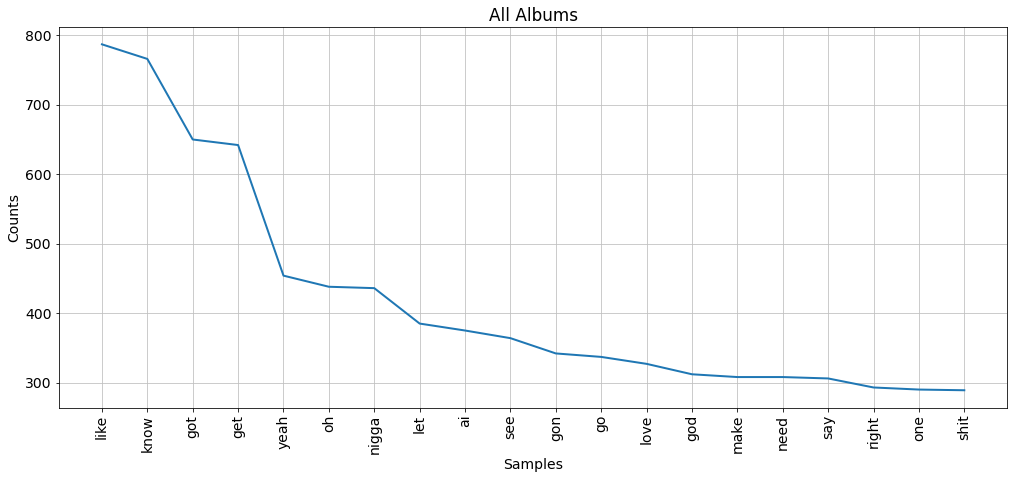

<AxesSubplot:title={'center':'All Albums'}, xlabel='Samples', ylabel='Counts'>

In [7]:
all_tokens = df_lyrics['lyrics_lem'].apply(pd.Series).stack()

freq_dist = nltk.probability.FreqDist(all_tokens)
for punc in string.punctuation:
    del freq_dist[punc]
freq_dist.plot(20, cumulative=False, title="All Albums")

Since we're looking towards difference between albums, we'll also create distributions grouped by album.

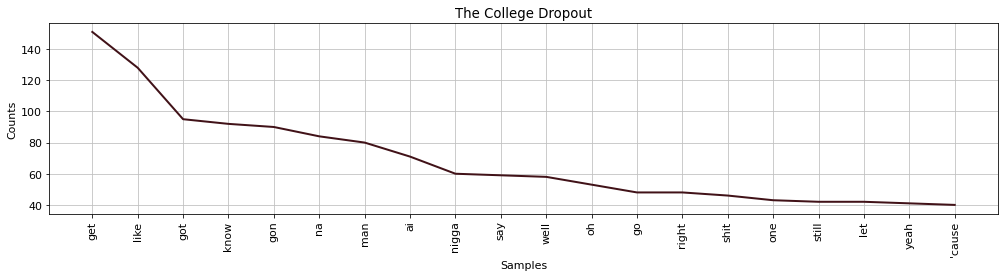

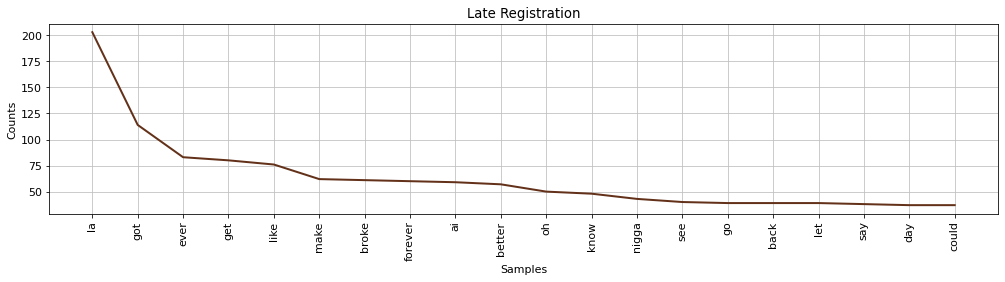

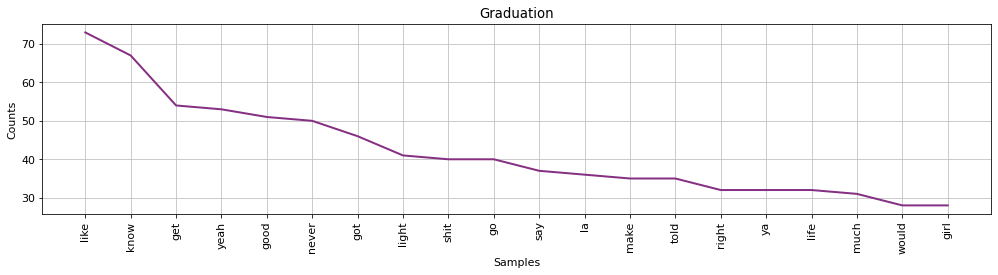

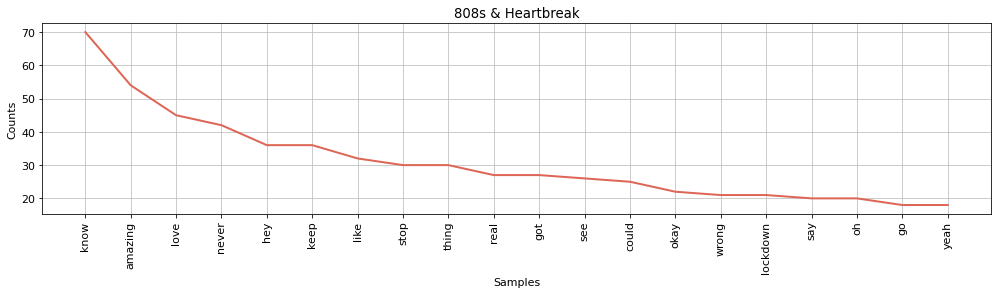

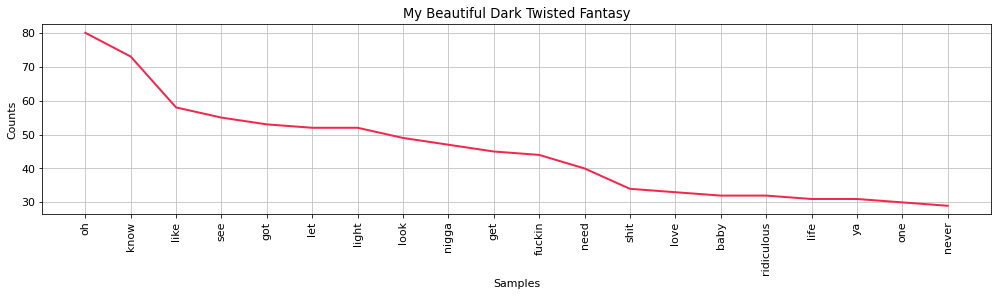

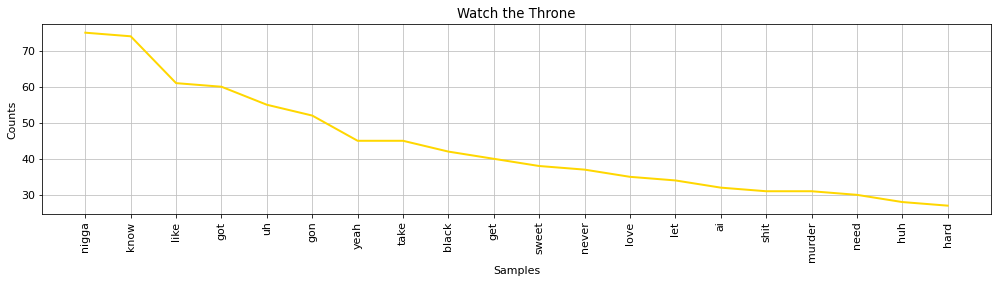

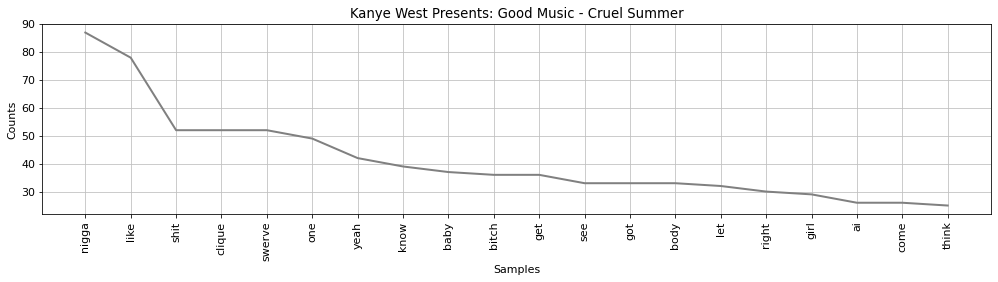

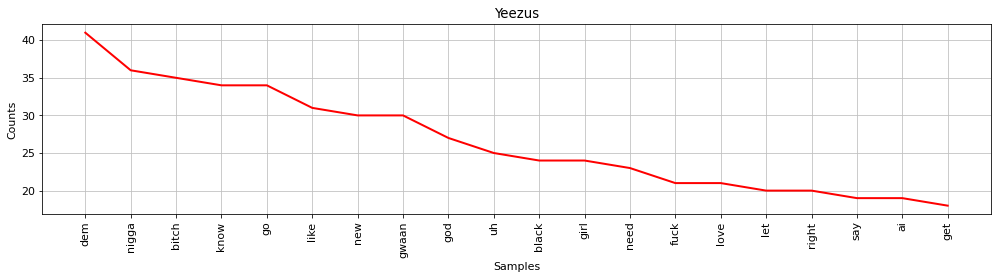

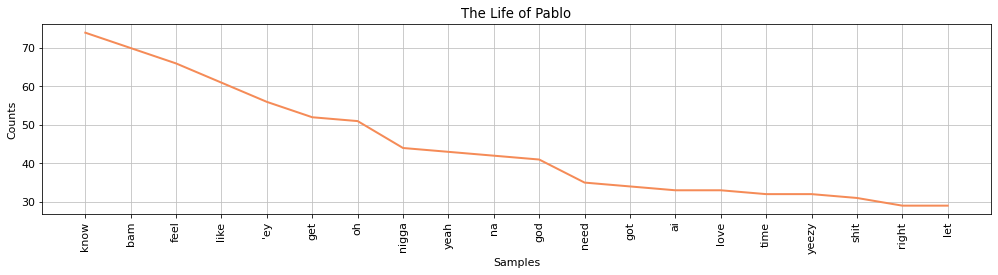

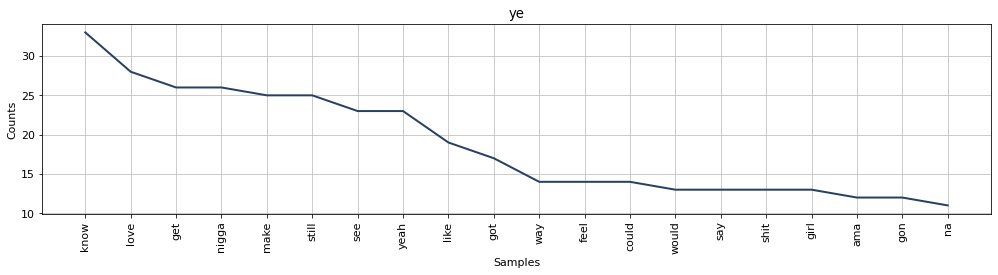

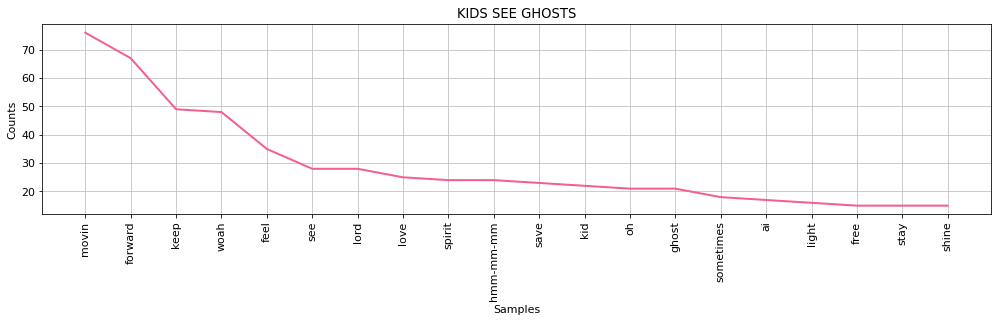

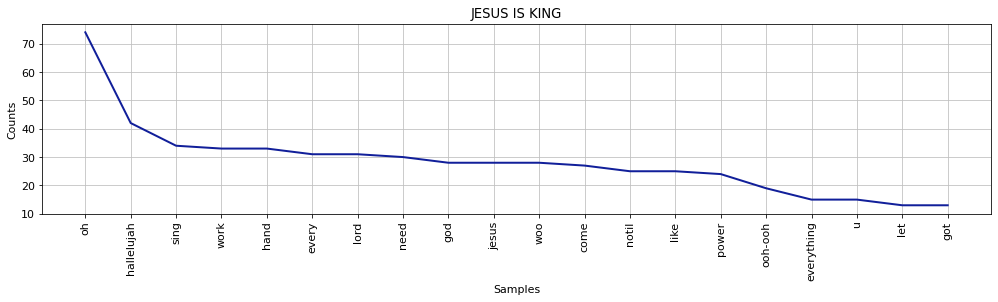

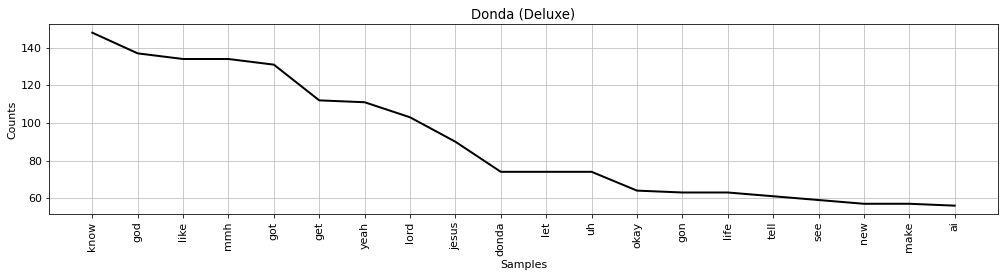

In [8]:
plt.rcParams['figure.figsize'] = (17, 3.5)
plt.rcParams.update({'font.size': 11})
colors = ['#411218', '#633119', '#853082', '#de6656', '#f2274c', '#ffd700', '#808080', 
          '#fe0000', '#f58b57', '#284061', '#F25E95', '#111F9A', '#000000']

for i, album in enumerate(df_lyrics['Album'].unique()):
    tokens = df_lyrics[df_lyrics['Album'] == album]['lyrics_lem'].apply(pd.Series).stack()
    freq_dist = nltk.probability.FreqDist(tokens)
    for punc in string.punctuation:
        del freq_dist[punc]
    ax1 = freq_dist.plot(20, cumulative=False, title=album, color=colors[i])

plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 14})

It's difficult to glean too much information from these distributions, as a majority of the words are quite common and don't convey too much information without context. However, it is worth noting that, towards the last three albums and "808's & Heartbreak", there is a noticeable shift in lexical choice, as they are the only albums within his discography that do not feature profanity or explicit language as their top 20 most used words. 

### 1) Lexical Diversity

Modern hip hop is often criticized for its departure from complex lyricism that old-school hip hop often featured. One of the most blatant offenders of this is Lil Pump's "Gucci Gang," which repeats the titular phrase in the song over fifty times. While Kanye West is not likely to reach repetition to that extent, it would be interesting to see whether the lyrical content of his music has gotten simpler and more repetitive given his longstanding career. In order to analyze this, we'll explore the lexical diversity of his lyrics by measuring each song's type-token ratio.

Type-token ratio measures the ratio of unique word stems (types) to the total number of the words (tokens). The logic behind this metric is that songs that are lyrically complex will have a wider vocabulary and will not repeat phrases as often. This would, in turn, increase the number of unique words contained within the body of text, and therefore increase the type-token ratio. Here, we make the conscious decision to exclude stopwords from our analysis in order to produce clearer results, as stopwords can potentially create noise within the data and deflate a song's type-token ratio.

In [9]:
def calculate_ttr(lyrics):
    for punc in string.punctuation:
        lyrics = list(filter(lambda x: x != punc, lyrics))
    return len(set(lyrics)) / len(lyrics)

df_lyrics['ttr'] = df_lyrics['lyrics_lem'].apply(calculate_ttr)
df_lyrics.head()

,Track Name,Album,Lyrics,lyrics_token,lyrics_stop,lyrics_lem,ttr
0,Intro,The College Dropout,"\nKanye, can I talk to you for a minute?\nMe a...","[kanye, ,, can, i, talk, to, you, for, a, minu...","[kanye, talk, minute, ?, faculty, members, won...","[kanye, talk, minute, ?, faculty, member, wond...",0.833333
1,We Don't Care,The College Dropout,"\nOh, yeah\nI got the perfect song for the kid...","[oh, ,, yeah, i, got, the, perfect, song, for,...","[oh, yeah, got, perfect, song, kids, sing, peo...","[oh, yeah, got, perfect, song, kid, sing, peop...",0.537838
2,Graduation Day,The College Dropout,"\nWhat in the fuck was that, Kanye?! I told yo...","[what, in, the, fuck, was, that, ,, kanye, ?, ...","[fuck, kanye, ?, !, told, shit, kids, !, give,...","[fuck, kanye, ?, !, told, shit, kid, !, give, ...",0.734043
3,All Falls Down,The College Dropout,"\nOh, when it all, it all falls down\nYeah, th...","[oh, ,, when, it, all, ,, it, all, falls, down...","[oh, falls, yeah, real, one, baby, tellin, fal...","[oh, fall, yeah, real, one, baby, tellin, fall...",0.594030
4,I'll Fly Away,The College Dropout,"\nOne glad morning, when this life is over, I ...","[one, glad, morning, ,, when, this, life, is, ...","[one, glad, morning, life, fly, away, land, jo...","[one, glad, morning, life, fly, away, land, jo...",0.640000


In [10]:
df_lyrics.describe()

,ttr
count,200.000000
mean,0.536329
std,0.131573
min,0.016949
25%,0.460622
50%,0.546518
75%,0.607146
max,0.882353


From this, we can see that a large majority of the data is located at the center, considering how close the 1st and 3rd quartile are to the median. There does seem to be some significant outliers given how far the min and max are from the medium and mean. Let's check them out.

In [11]:
df_lyrics[df_lyrics['ttr'] < 0.25]

,Track Name,Album,Lyrics,lyrics_token,lyrics_stop,lyrics_lem,ttr
34,Skit #2,Late Registration,"We broke, broke broke phi broke\nWe ai not got...","[we, broke, ,, broke, broke, phi, broke, we, a...","[broke, broke, broke, phi, broke, ai, got, bro...","[broke, broke, broke, phi, broke, ai, got, bro...",0.191176
159,Reborn,KIDS SEE GHOSTS,"\nHmm, I am wide awake, I’m wide awake\nI am w...","[hmm, ,, i, am, wide, awake, ,, i, ’, m, wide,...","[hmm, wide, awake, ’, wide, awake, wide, awake...","[hmm, wide, awake, ’, wide, awake, wide, awake...",0.235616
162,Every Hour,JESUS IS KING,"\nSing every hour (Every hour, notil the powe...","[sing, every, hour, (, every, hour, ,, notil, ...","[sing, every, hour, every, hour, notil, power,...","[sing, every, hour, every, hour, notil, power,...",0.130841
173,Donda Chant,Donda (Deluxe),"\nDonda, Donda, Donda, Donda, Donda, Donda\nDo...","[donda, ,, donda, ,, donda, ,, donda, ,, donda...","[donda, donda, donda, donda, donda, donda, don...","[donda, donda, donda, donda, donda, donda, don...",0.016949


In [12]:
df_lyrics[df_lyrics['ttr'] > 0.75]

,Track Name,Album,Lyrics,lyrics_token,lyrics_stop,lyrics_lem,ttr
0,Intro,The College Dropout,"\nKanye, can I talk to you for a minute?\nMe a...","[kanye, ,, can, i, talk, to, you, for, a, minu...","[kanye, talk, minute, ?, faculty, members, won...","[kanye, talk, minute, ?, faculty, member, wond...",0.833333
13,School Spirit (Skit 1),The College Dropout,"\nNow beat that!\nAnd your mother is saying ""G...","[now, beat, that, !, and, your, mother, is, sa...","[beat, !, mother, saying, go, college, finish,...","[beat, !, mother, saying, go, college, finish,...",0.819820
16,Lil' Jimmy (Skit),The College Dropout,"Hey Jimmy, where you going?\nI do not know whe...","[hey, jimmy, ,, where, you, going, ?, i, do, n...","[hey, jimmy, going, ?, know, goin', dad, died,...","[hey, jimmy, going, ?, know, goin', dad, died,...",0.771930
29,My Way Home,Late Registration,\n\nYeah\nI am on my way home\n\nThey say home...,"[yeah, i, am, on, my, way, home, they, say, ho...","[yeah, way, home, say, home, hate, dome, fate,...","[yeah, way, home, say, home, hate, dome, fate,...",0.829060
43,Back to Basics,Late Registration,"\nUh, uh, let is take it back to basics\nWhen ...","[uh, ,, uh, ,, let, is, take, it, back, to, ba...","[uh, uh, let, take, back, basics, shit, gets, ...","[uh, uh, let, take, back, basic, shit, get, wo...",0.753846
87,Who Will Survive In America,My Beautiful Dark Twisted Fantasy,\nUs living as we do upside-down\nAnd the new ...,"[us, living, as, we, do, upside-down, and, the...","[us, living, upside-down, new, word, revolutio...","[u, living, upside-down, new, word, revolution...",0.841667
92,Otis,Watch the Throne,"\nIt makes it easier, easier to bear\nYou will...","[it, makes, it, easier, ,, easier, to, bear, y...","[makes, easier, easier, bear, regret, girls, f...","[make, easier, easier, bear, regret, girl, for...",0.818966
140,Frank's Track,The Life of Pablo,"\nThe rings all ringed out\nBurn out, cave in\...","[the, rings, all, ringed, out, burn, out, ,, c...","[rings, ringed, burn, cave, blackened, dark, m...","[ring, ringed, burn, cave, blackened, dark, mi...",0.882353
165,Closed on Sunday,JESUS IS KING,"\nClosed on Sunday, you are my Chick-fil-A\nCl...","[closed, on, sunday, ,, you, are, my, chick-fi...","[closed, sunday, chick-fil-a, closed, sunday, ...","[closed, sunday, chick-fil-a, closed, sunday, ...",0.800000
166,On God,JESUS IS KING,"\nYo, Pi'erre, yo, Pi'erre\n\n""How you get so ...","[yo, ,, pi'erre, ,, yo, ,, pi'erre, '', how, y...","[yo, pi'erre, yo, pi'erre, get, much, favor, s...","[yo, pi'erre, yo, pi'erre, get, much, favor, s...",0.859155


There doesn't seem to anything here that looks off and would be worth removing to the point where it would significantly affect results. While one would expect shorter songs to be less likely to be repetitive due to less opportunity to repeat lyrics, this does not always seem to be the case, as we see 'Skit #2' and 'Donda Chant' near the lowest values, both of which are songs that are shorter than one minute.

Let's see how it breaks down by album.

In [13]:
df_lyrics.groupby('Album', sort=False).describe()

ttr                      \
                                               count      mean       std   
Album                                                                      
The College Dropout                             22.0  0.602287  0.119904   
Late Registration                               23.0  0.550542  0.131463   
Graduation                                      15.0  0.505870  0.098909   
808s & Heartbreak                               12.0  0.407002  0.075512   
My Beautiful Dark Twisted Fantasy               13.0  0.550221  0.140369   
Watch the Throne                                16.0  0.601671  0.112540   
Kanye West Presents: Good Music - Cruel Summer  12.0  0.550751  0.079029   
Yeezus                                          10.0  0.567511  0.073665   
The Life of Pablo                               20.0  0.539149  0.128210   
ye                                               7.0  0.551147  0.060098   
KIDS SEE GHOSTS                                  7.0  0.504971  0.167422   
JESUS IS KING                                   11.0  0.522974  0.221720   
Donda (Deluxe)                                  32.0  0.496522  0.135141   

                                                                              \
                                                     min       25%       50%   
Album                                                                          
The College Dropout                             0.363785  0.539111  0.599989   
Late Registration                               0.191176  0.500598  0.560656   
Graduation                                      0.256148  0.435768  0.554585   
808s & Heartbreak                               0.276190  0.360700  0.409944   
My Beautiful Dark Twisted Fantasy               0.365854  0.470588  0.551971   
Watch the Throne                                0.337500  0.534320  0.621209   
Kanye West Presents: Good Music - Cruel Summer  0.439759  0.496279  0.542614   
Yeezus                                          0.445415  0.518419  0.587582   
The Life of Pablo                               0.272727  0.474439  0.548894   
ye                                              0.460000  0.517106  0.558559   
KIDS SEE GHOSTS                                 0.235616  0.417292  0.536232   
JESUS IS KING                                   0.130841  0.384691  0.510460   
Donda (Deluxe)                                  0.016949  0.455243  0.513466   

                                                                    
                                                     75%       max  
Album                                                               
The College Dropout                             0.654574  0.833333  
Late Registration                               0.612162  0.829060  
Graduation                                      0.563478  0.612167  
808s & Heartbreak                               0.457177  0.511628  
My Beautiful Dark Twisted Fantasy               0.589404  0.841667  
Watch the Throne                                0.666884  0.818966  
Kanye West Presents: Good Music - Cruel Summer  0.582438  0.726950  
Yeezus                                          0.593208  0.666667  
The Life of Pablo                               0.606938  0.882353  
ye                                              0.585063  0.635135  
KIDS SEE GHOSTS                                 0.615442  0.697479  
JESUS IS KING                                   0.681313  0.859155  
Donda (Deluxe)                                  0.571062  0.700375

It is interesting to note that the data consistently stays around a TTR value of 0.5 both in mean and median, with the only significant deviation being in "808's & Heartbreaks." We'll proceed with a visualization.

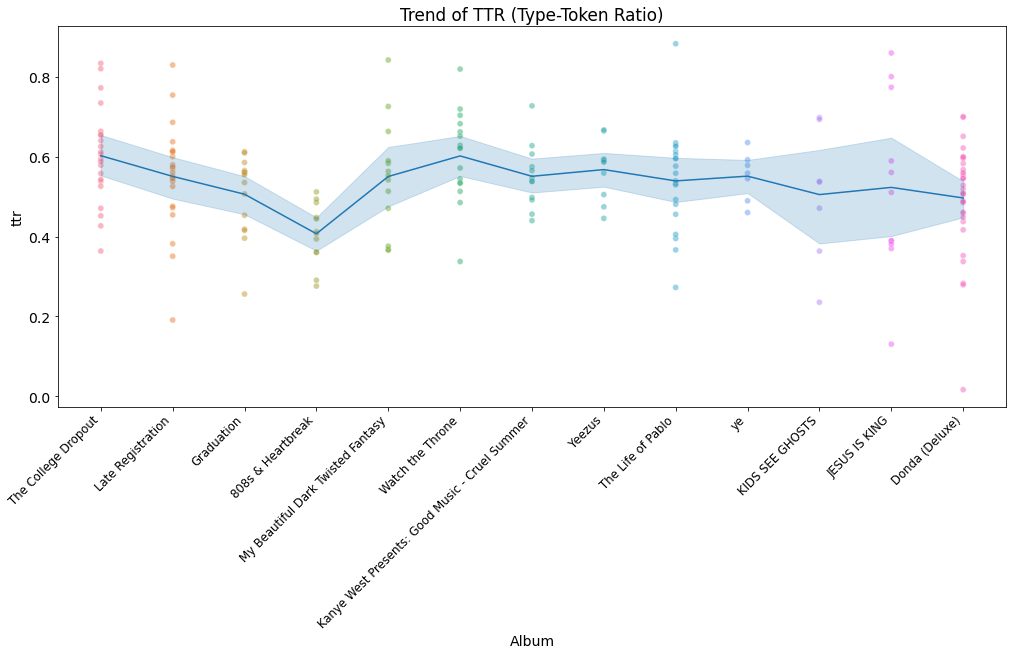

In [14]:
ax = sns.scatterplot(data=df_lyrics, x='Album', y='ttr', hue='Album', legend=False, alpha=0.5)
ax.set(title="Trend of TTR (Type-Token Ratio)")
ax.set_xticklabels(
    labels=df_lyrics['Album'].unique(),
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'  
)
ax2 = sns.lineplot(data=df_lyrics, x='Album', y='ttr')

Here, we surprisingly see an extreme consistency among the amount of repetition that is present in his songs. As could be seen in the descriptive statistics calculated earlier, the line is nearly horizontal across a 0.5 type-token ratio, even across a 13 album career. The fact that there is a dip towards "Graduation" and "808's & Heartbreak' is not surprising though, as these two albums had a far more pop aesthetic than the albums that trailed and followed it. 

### 2) Sentiment Analysis

Next, we'll look to explore trends in sentiment across all his albums. Sentiment analysis attempts to parse the emotional content of a body of text and output a quantifiable score. Here, we'll take a lexicon-based approach and use nltk's built-in VADER, which is a pre-trained sentiment model often used for analyzing social media. This application is quite close to ours, as the informal nature of his lyrics and heavy use of slang should closely resemble what is often written in social media.

In [15]:
vader = SentimentIntensityAnalyzer()
df_sentiment = pd.DataFrame()
lyrics_list = list(df_lyrics['Lyrics'].values)

for lyrics in lyrics_list:
    row = vader.polarity_scores(lyrics)
    row['song_name'] = df_lyrics.loc[df_lyrics['Lyrics'] == lyrics]['Track Name'].item()
    row['album'] = df_lyrics.loc[df_lyrics['Lyrics'] == lyrics]['Album'].item()
    row['lyrics'] = lyrics
    df_sentiment = df_sentiment.append(row, ignore_index=True)
    
df_sentiment

,neg,neu,pos,compound,song_name,album,lyrics
0,0.000,0.875,0.125,0.8577,Intro,The College Dropout,"\nKanye, can I talk to you for a minute?\nMe a..."
1,0.118,0.816,0.066,-0.9923,We Don't Care,The College Dropout,"\nOh, yeah\nI got the perfect song for the kid..."
2,0.137,0.801,0.062,-0.9490,Graduation Day,The College Dropout,"\nWhat in the fuck was that, Kanye?! I told yo..."
3,0.075,0.802,0.123,0.9897,All Falls Down,The College Dropout,"\nOh, when it all, it all falls down\nYeah, th..."
4,0.075,0.651,0.274,0.8860,I'll Fly Away,The College Dropout,"\nOne glad morning, when this life is over, I ..."
...,...,...,...,...,...,...,...
195,0.099,0.797,0.104,-0.8083,Jesus Lord,Donda (Deluxe),\nTell me if you know someone that needs (Jesu...
196,0.076,0.781,0.144,0.9727,Ok Ok pt 2 (Deluxe Version),Donda (Deluxe),"\nOkay, now they got me wanna rap again\nHeale..."
197,0.028,0.884,0.088,0.9837,Junya pt 2,Donda (Deluxe),"\nJunya Watanabe on my wri', wri'\nJunya Watan..."
198,0.098,0.765,0.137,0.9580,Jail pt 2,Donda (Deluxe),\nTake what you want\nTake everything\nTake wh...


In terms of interpretation, VADER works by calculating three scores that sum to 1: positivity (pos), negativity (neg), and neutrality (neu). It then creates a composite score based off these three scores, compound, which ranges from -1 to 1. By this logic, any score close to 0 is neutral, anything above 0 is some degree of positive, and anything below 0 is some degree of negative.

Let's see how the data looks for the collective whole.

In [16]:
df_sentiment.describe()

,neg,neu,pos,compound
count,200.000000,200.000000,200.000000,200.000000
mean,0.102345,0.763785,0.133860,0.232681
std,0.065797,0.088361,0.077428,0.902053
min,0.000000,0.351000,0.000000,-0.999900
25%,0.058750,0.719750,0.086750,-0.964000
50%,0.089500,0.774500,0.123000,0.901950
75%,0.135000,0.815250,0.158500,0.992275
max,0.423000,1.000000,0.604000,0.999900


The most notable statistic here is the one's representing spread. Although the mean of 0.24 suggests that his music leans towards positive, the spread of the data is evidently massive, considering how high the standard deviation and interquartile range are, relatively speaking.

Now, let's see how it looks by album.

In [17]:
df_sentiment[['compound', 'album']].groupby('album', sort=False).describe()

compound                      \
                                                  count      mean       std   
album                                                                         
The College Dropout                                22.0  0.260264  0.883348   
Late Registration                                  23.0  0.130309  0.931396   
Graduation                                         15.0  0.456567  0.904850   
808s & Heartbreak                                  12.0  0.441925  0.873437   
My Beautiful Dark Twisted Fantasy                  13.0 -0.321177  0.886063   
Watch the Throne                                   16.0 -0.249088  0.908607   
Kanye West Presents: Good Music - Cruel Summer     12.0  0.092242  0.971926   
Yeezus                                             10.0 -0.756420  0.618533   
The Life of Pablo                                  20.0  0.368235  0.903214   
ye                                                  7.0 -0.334443  0.933330   
KIDS SEE GHOSTS                                     7.0  0.429286  0.826275   
JESUS IS KING                                      11.0  0.874064  0.294703   
Donda (Deluxe)                                     32.0  0.707387  0.606090   

                                                                           \
                                                   min       25%      50%   
album                                                                       
The College Dropout                            -0.9997 -0.939525  0.83310   
Late Registration                              -0.9921 -0.924100  0.72030   
Graduation                                     -0.9991 -0.012100  0.97820   
808s & Heartbreak                              -0.9981  0.049450  0.97225   
My Beautiful Dark Twisted Fantasy              -0.9997 -0.996400 -0.98320   
Watch the Throne                               -0.9991 -0.985000 -0.81420   
Kanye West Presents: Good Music - Cruel Summer -0.9999 -0.996725  0.65285   
Yeezus                                         -0.9992 -0.995700 -0.98450   
The Life of Pablo                              -0.9973 -0.922750  0.93885   
ye                                             -0.9983 -0.990850 -0.93790   
KIDS SEE GHOSTS                                -0.9921  0.005000  0.99420   
JESUS IS KING                                   0.0000  0.923750  0.97900   
Donda (Deluxe)                                 -0.8456  0.926575  0.97940   

                                                                  
                                                     75%     max  
album                                                             
The College Dropout                             0.954900  0.9994  
Late Registration                               0.989400  0.9990  
Graduation                                      0.990400  0.9985  
808s & Heartbreak                               0.995750  0.9996  
My Beautiful Dark Twisted Fantasy               0.530600  0.9965  
Watch the Throne                                0.833950  0.9985  
Kanye West Presents: Good Music - Cruel Summer  0.950975  0.9986  
Yeezus                                         -0.966925  0.9765  
The Life of Pablo                               0.991000  0.9977  
ye                                              0.289100  0.9986  
KIDS SEE GHOSTS                                 0.996750  0.9994  
JESUS IS KING                                   0.995600  0.9999  
Donda (Deluxe)                                  0.995325  0.9992

Here, we can see that the values vary pretty highly from song to song and album to album, so it might be helpful to look at the distribution of songs within each album.

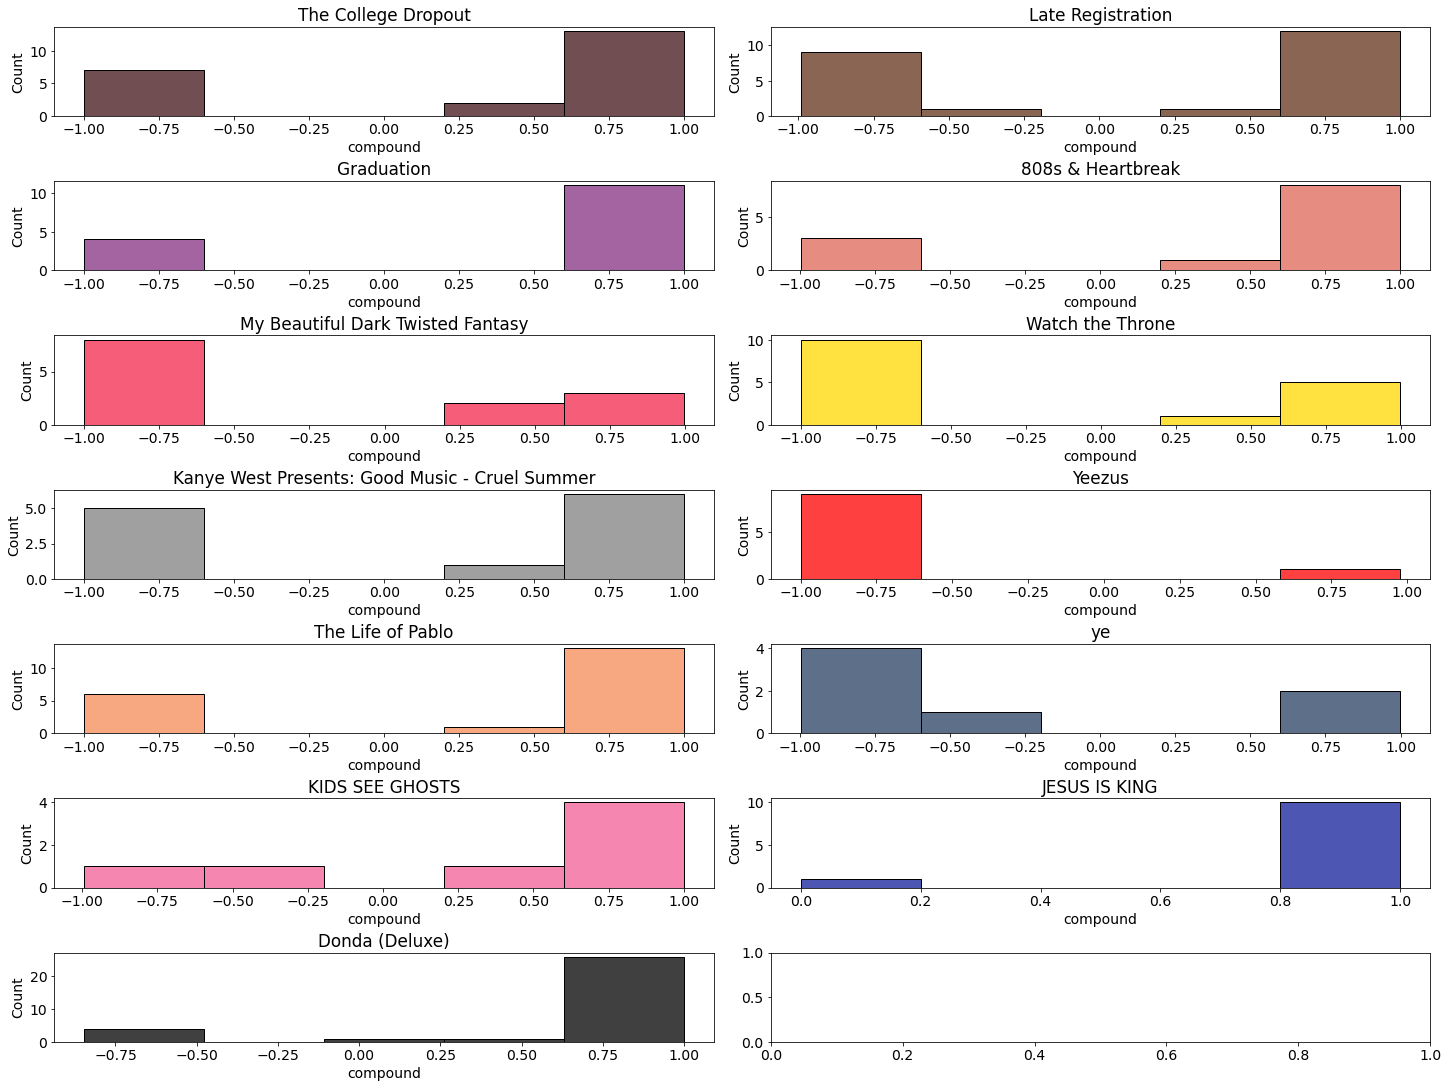

In [18]:
fig, axes = plt.subplots(7, 2, figsize=(20,15), constrained_layout=True)
axes = axes.flatten()
for i, album in enumerate(df_lyrics['Album'].unique()):
    sns.histplot(data=df_sentiment[df_sentiment['album'] == album], x='compound', ax=axes[i], color=colors[i], bins=5)
    axes[i].set_title(album)

From this, we can see that for most albums, there are either songs that are extremely positive or extremely negative, with little inbetween. Logically, this must be why the spread is so high for each of the albums.

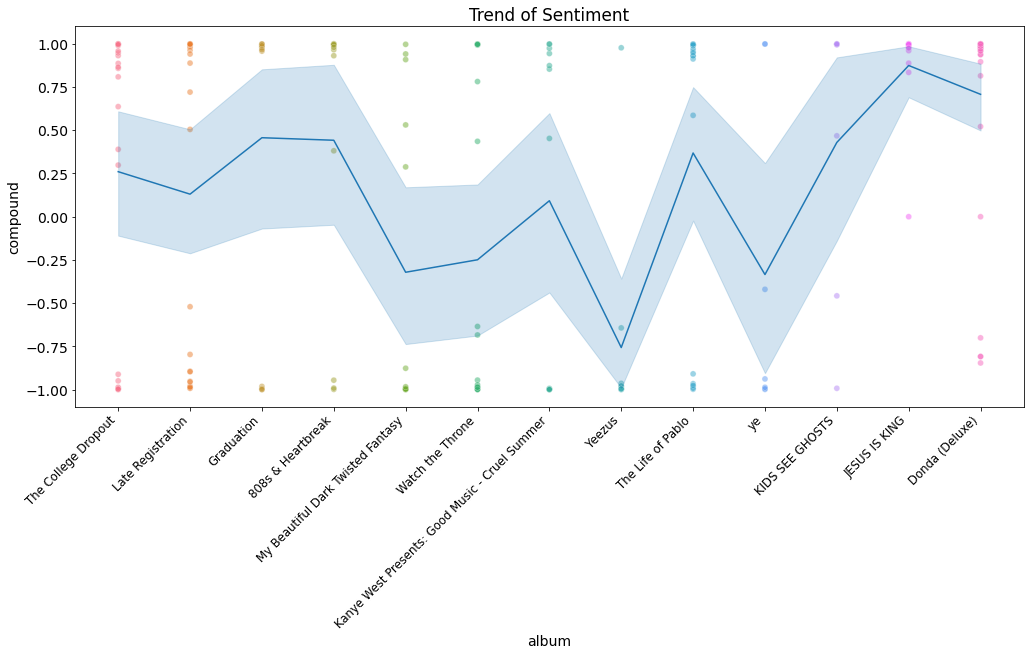

In [19]:
ax = sns.scatterplot(data=df_sentiment, x='album', y='compound', hue='album', legend=False, alpha=0.5)
ax.set(title="Trend of Sentiment")
ax.set_xticklabels(
    labels=df_lyrics['Album'].unique(),
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'  
)
ax2 = sns.lineplot(data=df_sentiment, x='album', y='compound')

This is a very interesting graph. Looking at the big picture, the trend does seem accurate from my listening experience. As for specific albums, some do feel very accurate, such as in "Yeezus", "JESUS IS KING", and "Donda (Deluxe)." However, there are many parts in which it completely diverts from expectations. Particularly, "808's & Heartbreaks' is an album known for a distinct departure from his usual style, as it was inspired by the breakup of his fiancée and the death of his mother. As a result, he explores the use of minimalistic autotune in order to convey pain, and much of the lyrics are based on themes of heartbreak and loss. Following this, we find it quite surprising how it has such a high score. On the other hand, many of his other albums, which did not feel quite as negative, consistently have songs that touch a value of -1.

One interesting thing to explore would be to somehow lower the weight that profanity impacts the analysis, as there is a possibility that its presence is skewing the results. This is because profanity is generally seen with a negative connotation, which would likely lower a song's compound VADER score. However, it is often the case in hip hop culture that artists use profanity without complete negative intention, and this is somewhat true with Kanye West. While VADER does consider context of the profanity, we will proceed to see if it helps produce better results.

Here, we grab a list of profanity words from an online source, and if the word is in VADER's lexicon, then its weight is halved.

In [20]:
response = urlopen('https://raw.githubusercontent.com/zacanger/profane-words/master/words.json')
swear_words = json.loads(response.read())

updated_vals = {}

for swear_word in swear_words:
    if (vader.lexicon.get(swear_word)):
        updated_vals[swear_word] = vader.lexicon.get(swear_word) / 2
        
vader.lexicon.update(updated_vals)

From here, we proceed with pretty much the same steps, using a different weight of the lexicon.

In [21]:
df_clean = pd.DataFrame()
lyrics_list = list(df_lyrics['Lyrics'].values)

for lyrics in lyrics_list:
    row = vader.polarity_scores(lyrics)
    row['song_name'] = df_lyrics.loc[df_lyrics['Lyrics'] == lyrics]['Track Name'].item()
    row['album'] = df_lyrics.loc[df_lyrics['Lyrics'] == lyrics]['Album'].item()
    row['lyrics'] = lyrics
    df_clean = df_clean.append(row, ignore_index=True)

In [22]:
df_clean.describe()

,neg,neu,pos,compound
count,200.000000,200.000000,200.000000,200.000000
mean,0.091545,0.773495,0.135035,0.352516
std,0.057556,0.086120,0.077385,0.860793
min,0.000000,0.351000,0.000000,-0.999600
25%,0.053000,0.733500,0.088000,-0.757375
50%,0.080000,0.782500,0.124000,0.953800
75%,0.117250,0.824250,0.161000,0.993700
max,0.421000,1.000000,0.604000,0.999900


In [23]:
df_clean[['compound', 'album']].groupby('album', sort=False).describe()

compound                      \
                                                  count      mean       std   
album                                                                         
The College Dropout                                22.0  0.331182  0.882184   
Late Registration                                  23.0  0.240870  0.902330   
Graduation                                         15.0  0.478760  0.879559   
808s & Heartbreak                                  12.0  0.442408  0.873762   
My Beautiful Dark Twisted Fantasy                  13.0 -0.119015  0.984666   
Watch the Throne                                   16.0  0.071119  0.914999   
Kanye West Presents: Good Music - Cruel Summer     12.0  0.297550  0.954302   
Yeezus                                             10.0 -0.523410  0.797602   
The Life of Pablo                                  20.0  0.572015  0.760711   
ye                                                  7.0 -0.210857  0.910641   
KIDS SEE GHOSTS                                     7.0  0.600157  0.738983   
JESUS IS KING                                      11.0  0.874073  0.294707   
Donda (Deluxe)                                     32.0  0.733731  0.572472   

                                                                           \
                                                   min       25%      50%   
album                                                                       
The College Dropout                            -0.9993 -0.782725  0.89095   
Late Registration                              -0.9917 -0.809950  0.89780   
Graduation                                     -0.9987  0.118850  0.98500   
808s & Heartbreak                              -0.9981  0.049450  0.97515   
My Beautiful Dark Twisted Fantasy              -0.9993 -0.990900 -0.97690   
Watch the Throne                               -0.9972 -0.947425  0.30890   
Kanye West Presents: Good Music - Cruel Summer -0.9996 -0.975025  0.94310   
Yeezus                                         -0.9972 -0.981525 -0.94160   
The Life of Pablo                              -0.9936  0.676350  0.97545   
ye                                             -0.9952 -0.936800 -0.72680   
KIDS SEE GHOSTS                                -0.9921  0.602400  0.99490   
JESUS IS KING                                   0.0000  0.923750  0.97900   
Donda (Deluxe)                                 -0.8083  0.933175  0.98125   

                                                                  
                                                     75%     max  
album                                                             
The College Dropout                             0.989550  0.9995  
Late Registration                               0.993400  0.9991  
Graduation                                      0.993350  0.9985  
808s & Heartbreak                               0.995750  0.9996  
My Beautiful Dark Twisted Fantasy               0.948600  0.9972  
Watch the Throne                                0.967150  0.9987  
Kanye West Presents: Good Music - Cruel Summer  0.993650  0.9986  
Yeezus                                         -0.550150  0.9793  
The Life of Pablo                               0.993250  0.9981  
ye                                              0.560500  0.9986  
KIDS SEE GHOSTS                                 0.997050  0.9994  
JESUS IS KING                                   0.995600  0.9999  
Donda (Deluxe)                                  0.995325  0.9993

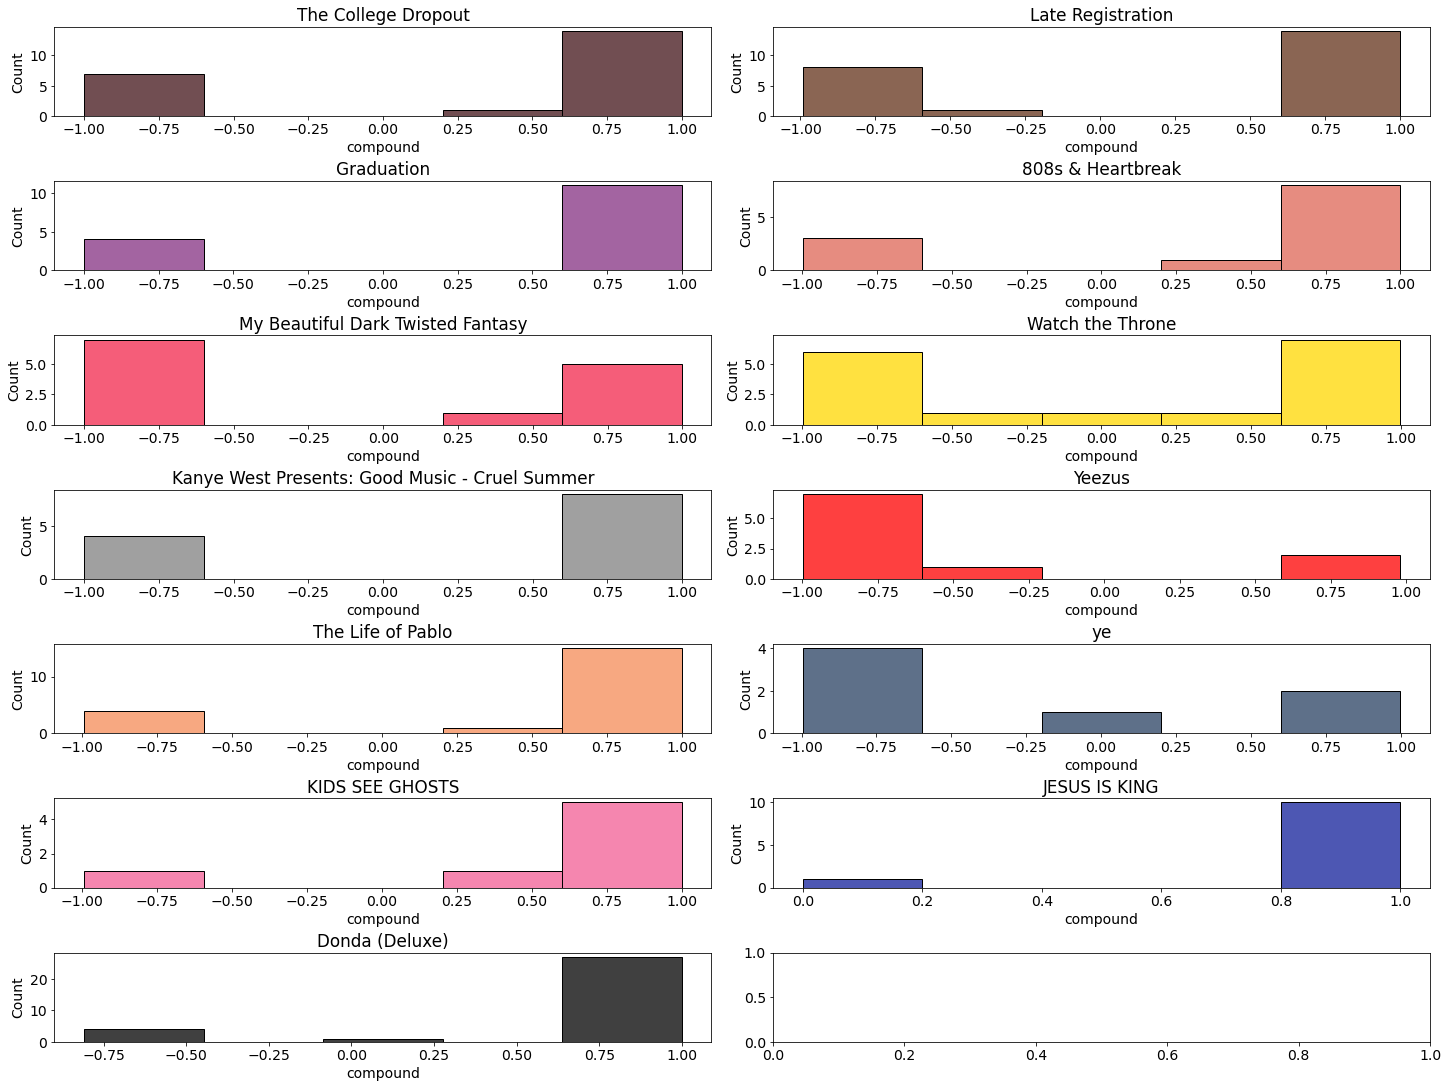

In [24]:
fig, axes = plt.subplots(7, 2, figsize=(20,15), constrained_layout=True)
axes = axes.flatten()
for i, album in enumerate(df_lyrics['Album'].unique()):
    sns.histplot(data=df_clean[df_clean['album'] == album], x='compound', ax=axes[i], color=colors[i], bins=5)
    axes[i].set_title(album)

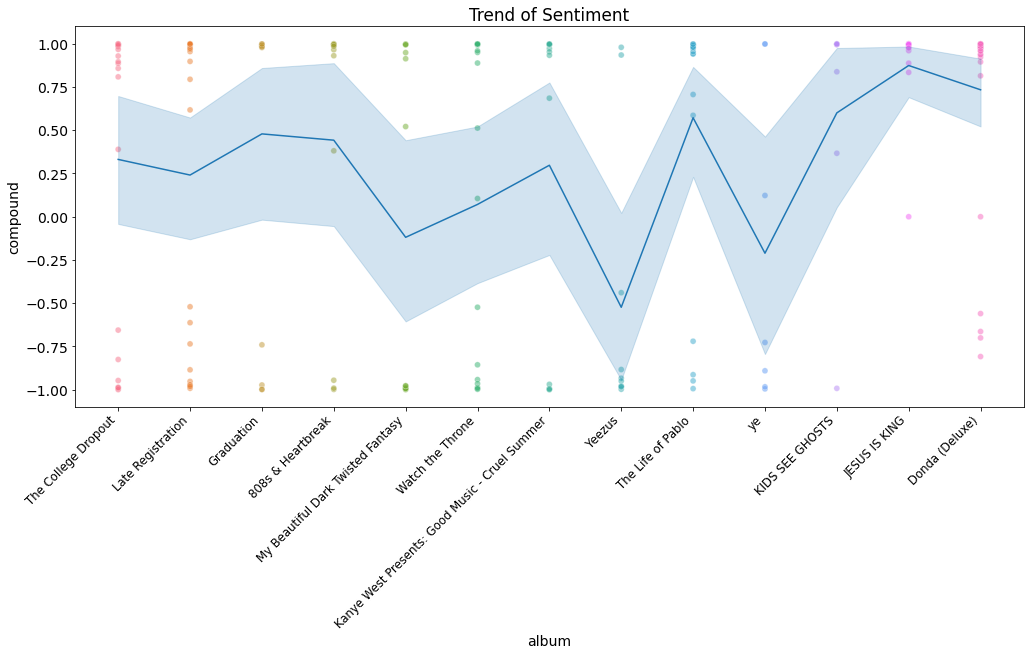

In [25]:
ax = sns.scatterplot(data=df_clean, x='album', y='compound', hue='album', legend=False, alpha=0.5)
ax.set(title="Trend of Sentiment")
ax.set_xticklabels(
    labels=df_lyrics['Album'].unique(),
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'  
)
ax2 = sns.lineplot(data=df_clean, x='album', y='compound')

From a comparison of the two graphs, the change increases the mean sentiment score by quite a bit (as expected), but changes very little in terms of the overall trend of the graph. As a result, it seems like profanity does not seem to be skewing the results towards what is unexpected, and any differences between our perception of the music is likely due to other characteristics of the music.

This does introduce a few questions though. We know that lowering the degree by which profanity affects VADER's analysis does not change the overall trend of the graph, which means that VADER does take into account the context of profanity, and that many of Kanye's songs are just intrinsically negative regardless of the profanity. However, it may be interesting to further explore this link between sentiment and profanity, which we saw a bit of by initially examining the word frequency distributions. Essentially, taking into account the fact that Kanye West curses even in positive songs, is the sentiment of Kanye West's songs correlated to the amount of profanity?

The raw count of profanity will be skewed towards longer songs and albums, so we'll instead look the proportion of his music that is profanity. We'll look into this by simply counting how many profane words are in each of his lemmatized songs and dividing that by the total word count.

In [26]:
def count_prof(lyrics):
    count = 0
    for lyric in lyrics:
        if lyric in swear_words:
            count += 1
    return count / len(lyrics)
    
df_prof = df_lyrics[['Track Name', 'Album', 'lyrics_lem']]
df_prof['prop_profanity'] = df_prof['lyrics_lem'].apply(count_prof)
df_prof['prop_profanity * 10'] = df_prof['lyrics_lem'].apply(lambda x : 10 * count_prof(x))
df_prof

,Track Name,Album,lyrics_lem,prop_profanity,prop_profanity * 10
0,Intro,The College Dropout,"[kanye, talk, minute, ?, faculty, member, wond...",0.000000,0.000000
1,We Don't Care,The College Dropout,"[oh, yeah, got, perfect, song, kid, sing, peop...",0.031915,0.319149
2,Graduation Day,The College Dropout,"[fuck, kanye, ?, !, told, shit, kid, !, give, ...",0.064815,0.648148
3,All Falls Down,The College Dropout,"[oh, fall, yeah, real, one, baby, tellin, fall...",0.017595,0.175953
4,I'll Fly Away,The College Dropout,"[one, glad, morning, life, fly, away, land, jo...",0.000000,0.000000
...,...,...,...,...,...
200,Jesus Lord,Donda (Deluxe),"[tell, know, someone, need, jesus, lord, lot, ...",0.009485,0.094851
201,Ok Ok pt 2 (Deluxe Version),Donda (Deluxe),"[okay, got, wan, na, rap, healed, wound, stab,...",0.000000,0.000000
202,Junya pt 2,Donda (Deluxe),"[junya, watanabe, wri, wri', junya, watanabe, ...",0.003003,0.030030
203,Jail pt 2,Donda (Deluxe),"[take, want, take, everything, take, want, tak...",0.012158,0.121581


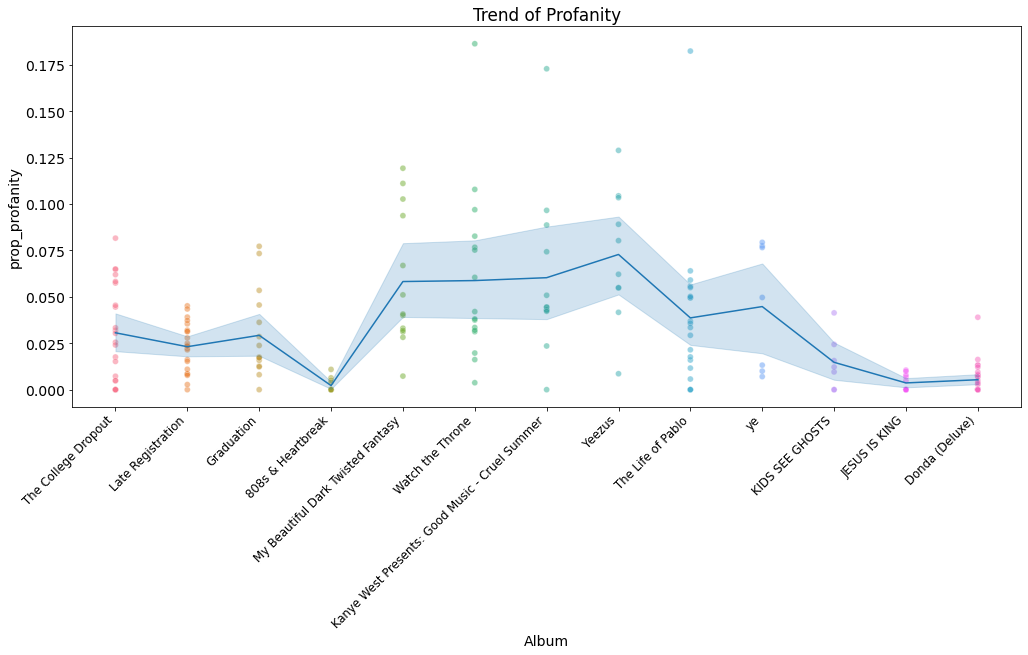

In [27]:
ax = sns.scatterplot(data=df_prof, x='Album', y='prop_profanity', hue='Album', legend=False, alpha=0.5)
ax.set(title="Trend of Profanity")
ax.set_xticklabels(
    labels=df_prof['Album'].unique(),
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'  
)
ax2 = sns.lineplot(data=df_prof, x='Album', y='prop_profanity')

Next, we'll look how this profanity score measures with the sentiment score of each respective album. Since the profanity proportion seems to fall between values of 0 and 0.2, we'll scale up the profanity score by a factor of 10 to make a visually better comparison.

Text(0, 0.5, '')

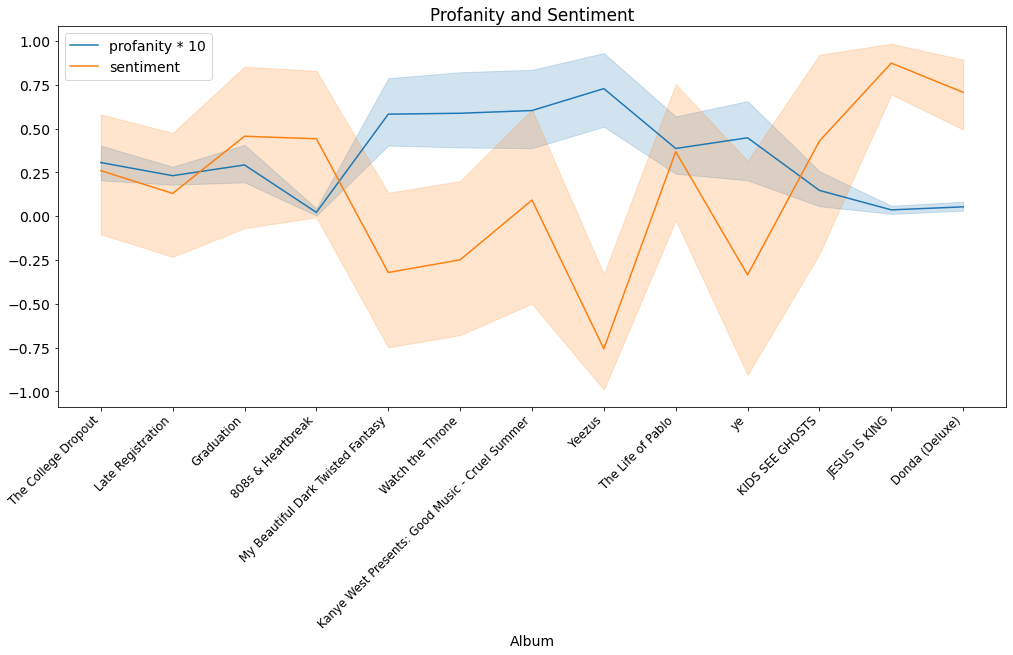

In [28]:
ax = sns.lineplot(data=df_prof, x='Album', y='prop_profanity * 10', legend='brief', label='profanity * 10')
ax.set(title="Profanity and Sentiment")
ax.set_xticklabels(
    labels=df_prof['Album'].unique(),
    rotation=45, 
    horizontalalignment='right',
    fontsize='small'  
)
ax.set_ylabel('')
ax2 = sns.lineplot(data=df_sentiment, x='album', y='compound', legend='brief', label='sentiment')
ax2.set_ylabel('')

Here, we see a positive correlation between the amount of profanity present in the songs and the sentiment of the songs. In fact, judging by how direct this correlation seems to be, it looks as if profanity is one of the main driving factors behind what decides sentiment.

## Song Attribute Analysis

Next, we tackle the question on whether musical attributes (danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo) have changed in Ye's music from his first album ("The College Dropout") to his most recent ("Donda (Deluxe)"). As shown earlier, we have access to such attributes via the Spotify API; however, we would ideally like to separate individual albums into distinct databases to access data easier. Since our analysis focuses on the trend of Ye's music over time, we must first sort the dataset to have the songs in chronological order.

In [29]:
# sort album in chronological order
df_spotify = df_spotify.sort_values(by='Release Date')

Now, as we can see, the data contains the albums in correct order based on release date.

In [30]:
df_spotify

,Track Name,Album,Release Date,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,Intro,The College Dropout,2004-02-10,0.713,0.331,6,-13.909,1,0.8770,0.23700,0.000000,0.510,0.463,87.491
20,Last Call,The College Dropout,2004-02-10,0.473,0.727,8,-6.843,1,0.3560,0.57700,0.000000,0.316,0.854,83.212
19,Family Business,The College Dropout,2004-02-10,0.744,0.524,1,-7.452,1,0.2100,0.13900,0.000000,0.392,0.606,93.691
18,Through The Wire,The College Dropout,2004-02-10,0.571,0.739,7,-6.110,1,0.2470,0.00865,0.000005,0.158,0.660,83.089
17,Two Words,The College Dropout,2004-02-10,0.442,0.807,6,-4.753,1,0.2650,0.01580,0.000006,0.217,0.446,84.649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Tell The Vision,Donda (Deluxe),2021-11-14,0.701,0.444,7,-10.814,0,0.0443,0.22000,0.000000,0.104,0.198,144.023
161,Jonah,Donda (Deluxe),2021-11-14,0.510,0.428,2,-8.455,0,0.2330,0.78500,0.000000,0.274,0.112,84.272
162,Pure Souls,Donda (Deluxe),2021-11-14,0.384,0.531,5,-6.965,1,0.0452,0.11700,0.000000,0.249,0.237,97.153
164,New Again,Donda (Deluxe),2021-11-14,0.594,0.669,6,-4.683,0,0.2020,0.05730,0.000000,0.409,0.263,91.371


Although possible to analyze all songs within Ye's discography, we decided against analyzing individual songs that are not part of albums. This is in part due songs having a much smaller sample size of characteristics, as we would be comparing a single song to an album that may contain up to 32 songs (as in the case of "Donda (Deluxe)"). Additionally, this allows us to see comparisons over the same dataset as the lyrical analysis above, as singles were removed due to lyric frequency being significantly lower in singles compared to albums. Thus, we remove the singles from the dataset

In [31]:
albums = []

# remove singles from dataset
for album in df_spotify['Album'].unique():
    if len(df_spotify[df_spotify['Album'] == album]) != 1:
        albums.append(album)
        
albums

['The College Dropout',
 'Late Registration',
 'Graduation',
 '808s & Heartbreak',
 'My Beautiful Dark Twisted Fantasy',
 'Watch The Throne (Deluxe)',
 'Kanye West Presents Good Music Cruel Summer',
 'Yeezus',
 'The Life Of Pablo',
 'ye',
 'KIDS SEE GHOSTS',
 'JESUS IS KING',
 'Donda (Deluxe)']

As we can see above, by filtering out the singles, we are now left with 12 albums to analyze, and within each album, there are 11 attributes to analyze for trends. In order to visualize the attributes within each individual album, we would therefore like to separate each album into its own database.

In [32]:
# create dataframe for all albums with more than one song
ye_album_dataframes = []

for album_name in albums:
    ye_album_dataframes.append(df_spotify[df_spotify['Album'] == album_name].reset_index())

Now, we are able to access the average values of the appropriate attributes via the .mean() command for albums within the kanye_album_dataframes list. For example, if we wanted to view the average value of attributes we seek for the album "808s & Heartbreak", since it is the fourth album of his discography, we simply do:

In [33]:
ye_album_dataframes[3].mean()

index                61.500000
Danceability          0.656167
Energy                0.480917
Key                   5.750000
Loudness             -9.316500
Mode                  0.416667
Speechiness           0.057975
Acousticness          0.206192
Instrumentalness      0.148945
Liveness              0.229450
Valence               0.350908
Tempo               119.701500
dtype: float64

Now that we have obtained the average values of all song attributes within albums into their own dataframes, we continue our quest in creating a dataframe with such values. Since we already obtained a list of all the albums stored in the variable 'albums', we continue to create lists of the average value of the remaining attributes. We begin by creating the column names of the desired attributes from the initial dataset

In [34]:
col_names = ['Albums']
col_names.extend(list(df_spotify.select_dtypes('number').columns.values))

col_names

['Albums',
 'Danceability',
 'Energy',
 'Key',
 'Loudness',
 'Mode',
 'Speechiness',
 'Acousticness',
 'Instrumentalness',
 'Liveness',
 'Valence',
 'Tempo']

Now that we have obtained the column names for our dataset, we begin by initializing an empty dataset.

In [35]:
song_comparison_df = pd.DataFrame(columns=col_names)

Now that the column names in our dataset are intialized, we will find the average values of each song

In [36]:
for iteration in range(len(ye_album_dataframes)):
    row_values = [albums[iteration]]
    for attribute in range(1, len(ye_album_dataframes[iteration].mean())):
        row_values.append(ye_album_dataframes[iteration].mean()[attribute])
    song_comparison_df.loc[len(song_comparison_df)] = row_values

Therefore, we have obtained our dataframe in which the rows have the album names as well as the average attribute values of their songs as columns of the dataframe.

In [37]:
song_comparison_df

,Albums,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,The College Dropout,0.579524,0.593571,5.571429,-7.796429,0.523810,0.407614,0.360022,6.542857e-07,0.321000,0.665000,109.784143
1,Late Registration,0.595619,0.636476,7.523810,-7.859238,0.523810,0.376400,0.180246,2.186633e-03,0.200981,0.520905,97.774524
2,Graduation,0.575857,0.622929,5.928571,-7.312714,0.571429,0.185464,0.116670,4.022857e-05,0.299229,0.519286,100.129286
3,808s & Heartbreak,0.656167,0.480917,5.750000,-9.316500,0.416667,0.057975,0.206192,1.489451e-01,0.229450,0.350908,119.701500
4,My Beautiful Dark Twisted Fantasy,0.522769,0.680938,4.461538,-5.939923,0.384615,0.131262,0.187443,4.737701e-02,0.393385,0.364715,111.951923
5,Watch The Throne (Deluxe),0.628882,0.735353,6.058824,-5.899588,0.529412,0.187347,0.180688,2.235422e-03,0.277671,0.419076,117.492529
6,Kanye West Presents Good Music Cruel Summer,0.544429,0.708000,5.857143,-5.467714,0.285714,0.279571,0.115211,3.314286e-06,0.254171,0.443857,134.970000
7,Yeezus,0.515100,0.589100,4.000000,-5.418100,0.600000,0.180070,0.184120,8.962800e-05,0.151580,0.360800,131.447300
8,The Life Of Pablo,0.621000,0.590850,6.050000,-6.036700,0.650000,0.273980,0.341461,1.161165e-04,0.239740,0.410605,116.146800
9,ye,0.685857,0.503429,5.000000,-5.668286,0.285714,0.314529,0.306743,0.000000e+00,0.185957,0.281386,121.362714


With the average values of each album's song attributes in a single dataframe, we are now able to graph the data to see if we are able to see any obvoious trends in the data over time. To do this, each individual attribute we are observing will be in its own graph. To make the averages of the attribute within each album evident, we will mark the average with red, and plot a line showing the trend of the average across all of Ye's albums. Thus, we first initialize the colors of our scatterplots.

In [38]:
colors = ["#000000", "#FF0000"]
palette = sns.set_palette(sns.color_palette(colors))

Since we are plotting the attribute values of each individual song within the album on a vertical strip, it would be in our best interest to have a database containing all of the songs from the albums we are observing data from. Thus, we must create one more dataframe containing songs from such albums.

In [39]:
# create new dataframe with all songs from each album to see spread of song attributes within each album compared to mean
albums_df = df_spotify[(df_spotify['Album']  == 'The College Dropout') | 
                               (df_spotify['Album']  == 'Late Registration') | 
                               (df_spotify['Album']  == 'Graduation') | 
                               (df_spotify['Album']  == '808s & Heartbreak') | 
                               (df_spotify['Album']  == 'My Beautiful Dark Twisted Fantasy') | 
                               (df_spotify['Album']  == 'Watch The Throne (Deluxe)') |
                               (df_spotify['Album']  == 'Yeezus') |
                               (df_spotify['Album']  == 'The Life Of Pablo') |
                               (df_spotify['Album']  == 'ye') |
                               (df_spotify['Album']  == 'KIDS SEE GHOSTS') |
                               (df_spotify['Album']  == 'JESUS IS KING') |
                               (df_spotify['Album']  == 'Donda (Deluxe)')
                              ]

We can see that albums_df now contains all of the songs that we are looking for within the dataset obtained from the Spotify API.

In [40]:
albums_df

,Track Name,Album,Release Date,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,Intro,The College Dropout,2004-02-10,0.713,0.331,6,-13.909,1,0.8770,0.23700,0.000000,0.510,0.463,87.491
20,Last Call,The College Dropout,2004-02-10,0.473,0.727,8,-6.843,1,0.3560,0.57700,0.000000,0.316,0.854,83.212
19,Family Business,The College Dropout,2004-02-10,0.744,0.524,1,-7.452,1,0.2100,0.13900,0.000000,0.392,0.606,93.691
18,Through The Wire,The College Dropout,2004-02-10,0.571,0.739,7,-6.110,1,0.2470,0.00865,0.000005,0.158,0.660,83.089
17,Two Words,The College Dropout,2004-02-10,0.442,0.807,6,-4.753,1,0.2650,0.01580,0.000006,0.217,0.446,84.649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Tell The Vision,Donda (Deluxe),2021-11-14,0.701,0.444,7,-10.814,0,0.0443,0.22000,0.000000,0.104,0.198,144.023
161,Jonah,Donda (Deluxe),2021-11-14,0.510,0.428,2,-8.455,0,0.2330,0.78500,0.000000,0.274,0.112,84.272
162,Pure Souls,Donda (Deluxe),2021-11-14,0.384,0.531,5,-6.965,1,0.0452,0.11700,0.000000,0.249,0.237,97.153
164,New Again,Donda (Deluxe),2021-11-14,0.594,0.669,6,-4.683,0,0.2020,0.05730,0.000000,0.409,0.263,91.371


Finally, with all the necessary data available in the dataframes albums_df and song_comparison_df, we are able to plot the data to see if any trends are visible across Ye's discography.

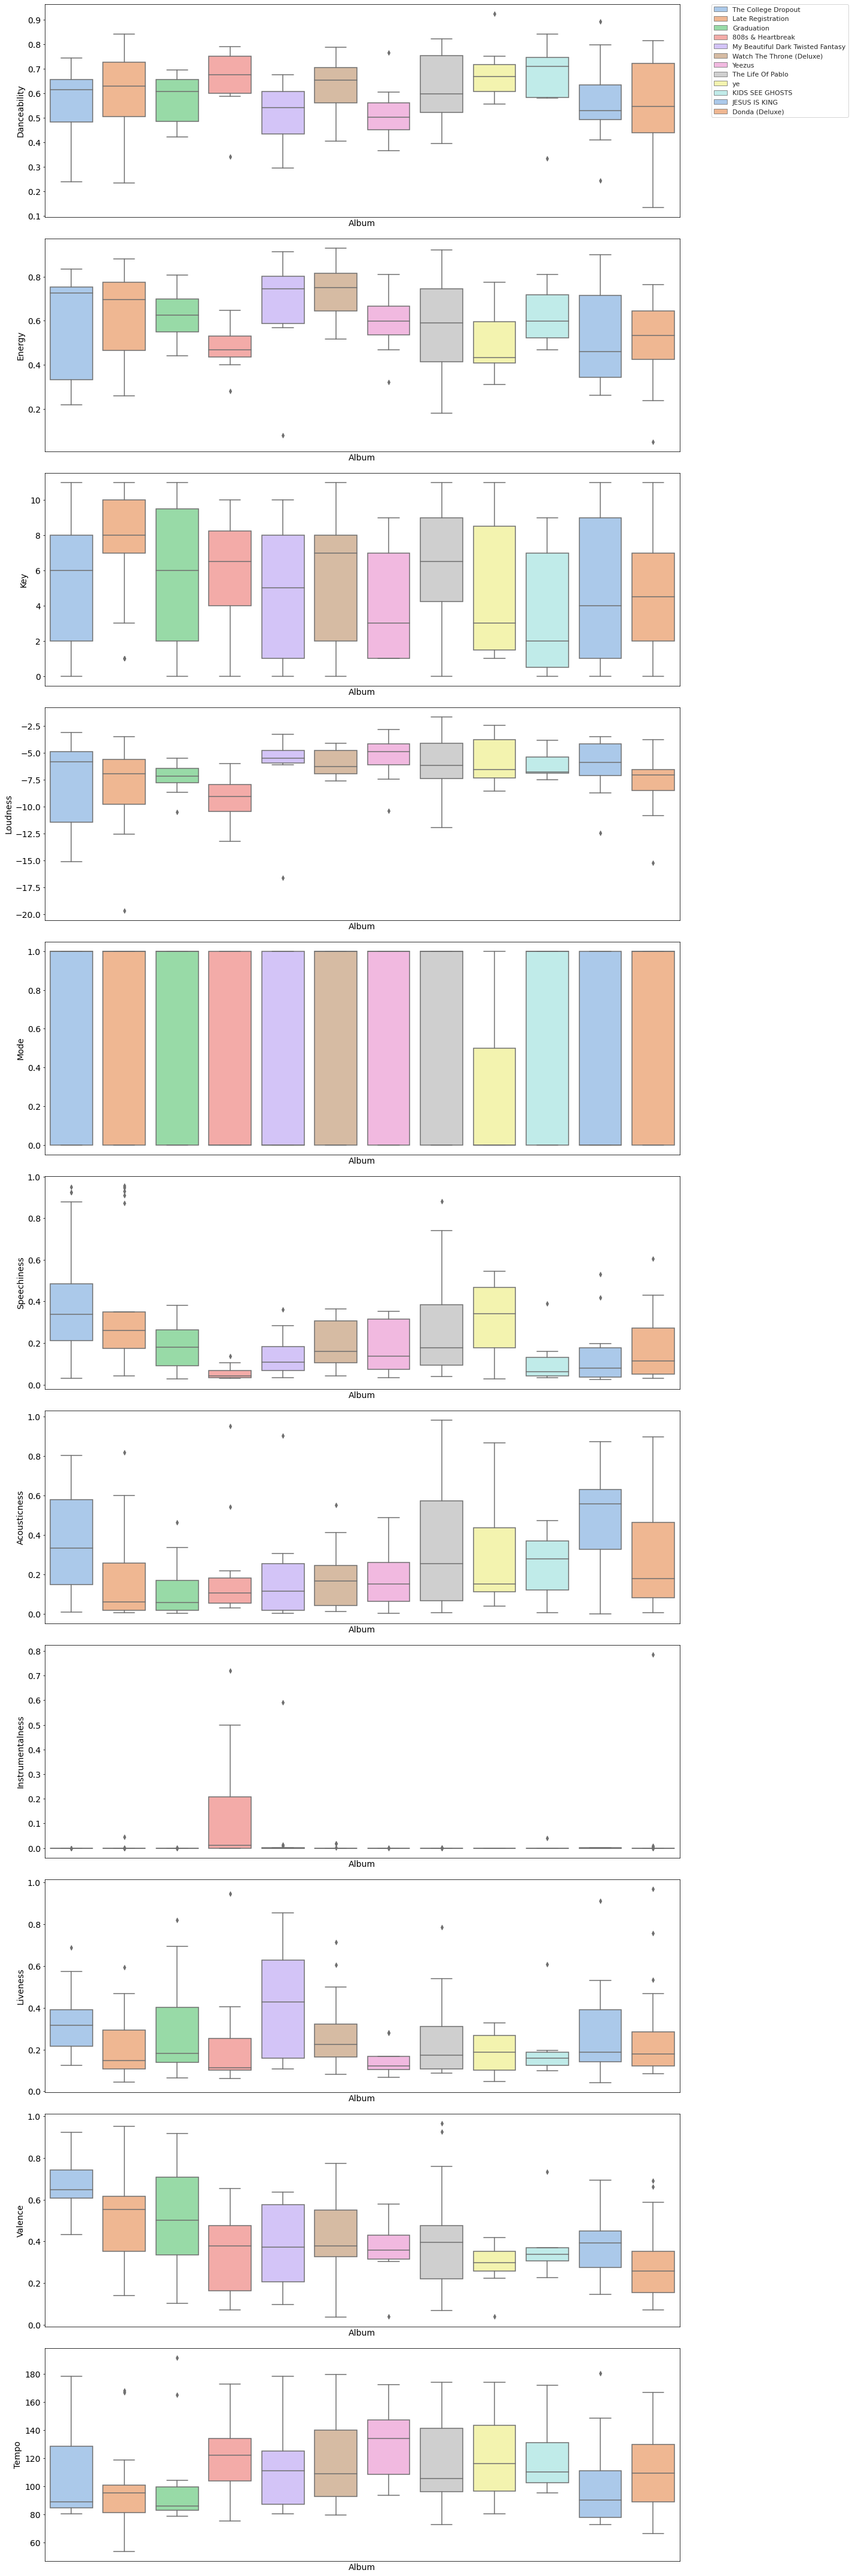

In [41]:
fig, axs = plt.subplots(11, 1)
axs = axs.flatten()

for iteration in range(1, len(col_names)):
    sns.set_theme(style="whitegrid")
    sns.boxplot(x='Album', y=col_names[iteration], hue='Album', 
                data=albums_df, palette ='pastel', ax=axs[iteration - 1], dodge=False).set_xticks([])
    if iteration == 1:
        axs[iteration - 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    else:
        axs[iteration - 1].legend([],[], frameon=False)
    plt.gcf().set_size_inches(20, 60)
fig.tight_layout()